#### Data 로딩

#### 결측치처리

#### encoding 대체

#### 모델링(set분리)

In [1]:
import pandas as pd
import numpy as np

cols = ['age', 'workclass','fnlwgt','education', 'education-num', 'marital-status', 'occupation','relationship', 'race', 'gender','capital-gain','capital-loss', 'hours-per-week','native-country','income']
category_columns = ['workclass','education','marital-status', 'occupation','relationship','race','gender','native-country']
number_columns = ['age','fnlwgt', 'education-num','capital-gain','capital-loss','hours-per-week']
target = "income"

##### 데이터 로딩

In [2]:
data = pd.read_csv(
    'data/adult.data', 
    # header=[0,1,2,3],      # 4번째 라인부터 데이터.
    header=None,      # 첫번째 라인부터 데이터일 경우.
    names=cols,       # header(컬럼명) 지정
    na_values='?',    # 결측치로 읽을 값 설정.
    skipinitialspace=True # 값 앞의 공백을 제거하고 읽는다. , abc -> ' abc', 'abc'
)
data.shape

(32561, 15)

In [31]:
# data.head()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [29]:
# data.isnull().sum()

In [28]:
# data['workclass'].value_counts()

In [27]:
# data['occupation'].value_counts()

In [26]:
# data['native-country'].value_counts()

In [35]:
df[number_columns]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40
...,...,...,...,...,...,...
32556,27,257302,12,0,0,38
32557,40,154374,9,0,0,40
32558,58,151910,9,0,0,40
32559,22,201490,9,0,0,20


#### 결측치 처리

In [13]:
# 최빈값으로 대체
from sklearn.impute import SimpleImputer
df = data.copy()
# A, B (수치형) => 중앙값, C(범주형) => 최빈값
imputer = SimpleImputer(strategy="most_frequent")

df[['workclass', 'occupation', 'native-country' ]] = imputer.fit_transform(df[['workclass', 'occupation', 'native-country' ]])  # 결측치를 어떤 값으로 바꿀지 학습. (2차원 -> 0축 기준으로 계산)
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [32]:
# df['occupation'].value_counts()

#### encoding
- Target(income) - Label Encoding
- Feature 중 범주형 - OneHot Encoding

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Target(income) - Label Encoding
le = LabelEncoder()
y = le.fit_transform(df['income'])
np.unique(y, return_counts=True)


(array([0, 1]), array([24720,  7841]))

In [50]:
# 범주형 feature를  One hot encoding
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df[category_columns])
cate_features.shape

(32561, 99)

In [45]:
# ohe.get_feature_names_out()
df[number_columns].values

array([[    39,  77516,     13,   2174,      0,     40],
       [    50,  83311,     13,      0,      0,     13],
       [    38, 215646,      9,      0,      0,     40],
       ...,
       [    58, 151910,      9,      0,      0,     40],
       [    22, 201490,      9,      0,      0,     20],
       [    52, 287927,      9,  15024,      0,     40]], shape=(32561, 6))

In [52]:
X = np.concatenate(
    [cate_features, df[number_columns].values],
    axis=1
)
X.shape, y.shape

((32561, 105), (32561,))

#### 모델링
##### train / validation / test set 분리

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from metrics import print_binary_classification_metrics

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train,random_state=0)
X_train.shape, X_val.shape, X_test.shape

((19536, 105), (6512, 105), (6513, 105))

#### 모델링
- 모델생성 - DecisionTreeClassifier
- 학습
- 검증

In [56]:
max_depth_list = [3,4,5,6,7,8,9,10]

result_train = []
result_val = []

for max_depth in max_depth_list:
    # 1. 모델생성
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    # 2. trainset으로 학습
    model.fit(X_train, y_train)
    # 3. 검증
    #     추론
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    #     검증
    result_train.append(accuracy_score(y_train, pred_train))
    result_val.append(accuracy_score(y_val, pred_val))

In [57]:
result_df = pd.DataFrame({
    'train_acc': result_train,
    'val_acc': result_val,
})
result_df.index = range(3, len(result_train)+3)
result_df.rename_axis(mapper='Max Depth', axis=0, inplace=True)
result_df

,train_acc,val_acc
Max Depth,,
3,0.846284,0.841677
4,0.847052,0.842138
5,0.855600,0.848280
6,0.859388,0.851044
7,0.862664,0.851812
8,0.866503,0.854115
9,0.870700,0.854269
10,0.875512,0.854115


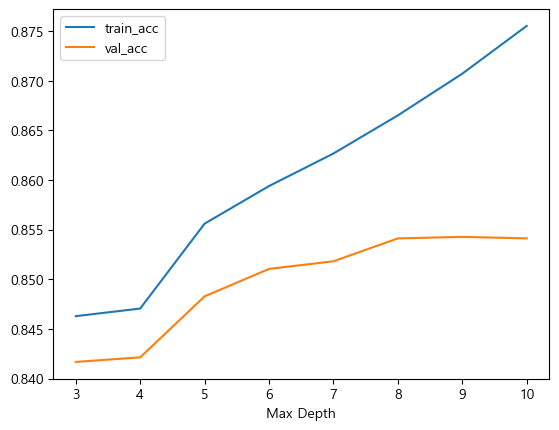

In [58]:
result_df.plot();

#### 최종평가


In [60]:
best_model =  DecisionTreeClassifier(max_depth=9, random_state=0)
best_model.fit(X_train, y_train)
accuracy_score(y_test, best_model.predict(X_test))

0.8529095654844158

In [61]:
print_binary_classification_metrics(y_test, best_model.predict(X_test))

정확도: 0.8529095654844158
재현율: 0.5803571428571429
정밀도: 0.7520661157024794
F1 점수: 0.6551475881929446


In [62]:
np.unique(y_train, return_counts=True)[1]/y_train.size

array([0.75916257, 0.24083743])